In [101]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.measure import find_contours

In [102]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

# Analysis of raw data

In [103]:
data_dir = '/Users/beantown/PycharmProjects/master-thesis/data/raw/michigan_data/'

In [104]:
def get_estimated_resulution(file_name):
    data_dir = '/Users/beantown/PycharmProjects/master-thesis/data/raw/michigan_data/'
    fpath = data_dir + file_name + '.jpg'
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # red color boundaries [B, G, R]
    lower = [55, 55, 55]
    upper = [70, 255, 255]

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask=mask)
    #ret,thresh = cv2.threshold(mask, 20, 255, 9)
    #contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    #result = np.hstack([image, output])
    result = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)
    gray_img = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
    
    contours = find_contours(gray_img, 0.8)
    
    Xlength = 0
    Ylength = 0

    for contour in contours:
        # get corners
        Xmin = np.min(contour[:,1])
        Xmax = np.max(contour[:,1])
        Ymin = np.min(contour[:,0])
        Ymax = np.max(contour[:,0])

        # get current pixel length for x and y-axis
        Xlength_new = abs(Xmin - Xmax)
        Ylength_new = abs(Ymin - Ymax)

        if Xlength_new > Xlength:
            Xlength = Xlength_new
            Ylength = Ylength_new

    # calculate pixels / cm (2.3 is given by the ruler of the site of images)
    Ylength = Ylength / 2.3
    Xlength = Xlength / 2.3
    
    #print(f'sucessfully calculated resolution for {file_name}')
    
    return [Ylength, Xlength]

In [112]:
def get_info(path):
    info_path = join(path, 'info.csv')
    if isfile(info_path): 
        info_frame = pd.read_csv(info_path, index_col=0, dtype={'fnames':str,'papyID':int,'posinfo':str, 'pixelCM_Y':float, 'pixelCM_X':float}, header=0)
    else:
        fnames = [f for f in listdir(path) if isfile(join(path, f))]
        fnames = [ x for x in fnames if ".jpg" in x ]
        fnames = [f.split('.',1)[0] for f in fnames]
        info_frame = pd.DataFrame(fnames, columns=['fnames'])
        info_frame['papyID'] = info_frame.fnames.apply(lambda x: x.split('_',1)[0])
        info_frame['posinfo'] = info_frame.fnames.apply(lambda x: ''.join(filter(str.isalpha, x)))
        info_path = join(path, 'info.csv')
        info_frame['pixelCentimer'] = info_frame.fnames.progress_apply(get_estimated_resulution)
        info_frame.to_csv(info_path)
    return info_frame

In [113]:
info_frame = get_info(data_dir)

In [118]:
info_frame

,fnames,papyID,posinfo,pixelCM_Y,pixelCM_X
0,11930_4233V,11930,V,231.298834,102.165627
1,13947_4857DV,13947,DV,97.818023,227.384677
2,10812_4101KR,10812,KR,100.425339,228.253931
3,13912_4803FV,13912,FV,229.122153,97.819632
4,10752_4097Z20R,10752,ZR,181.294879,412.601164
...,...,...,...,...,...
8848,12086_4240LV,12086,LV,99.556818,228.255498
8849,11368_4139BR,11368,BR,139.123257,60.427198
8850,15493_3585WR,15493,WR,99.121569,227.384945
8851,8607_2155R,8607,R,229.990194,99.557066


In [115]:
id_series = info_frame.groupby('papyID')['fnames'].nunique().sort_values(ascending=False)
id_series

papyID
9876     22
14167     9
17310     7
1290      7
4216      6
         ..
11177     1
11176     1
11171     1
11170     1
18642     1
Name: fnames, Length: 7380, dtype: int64

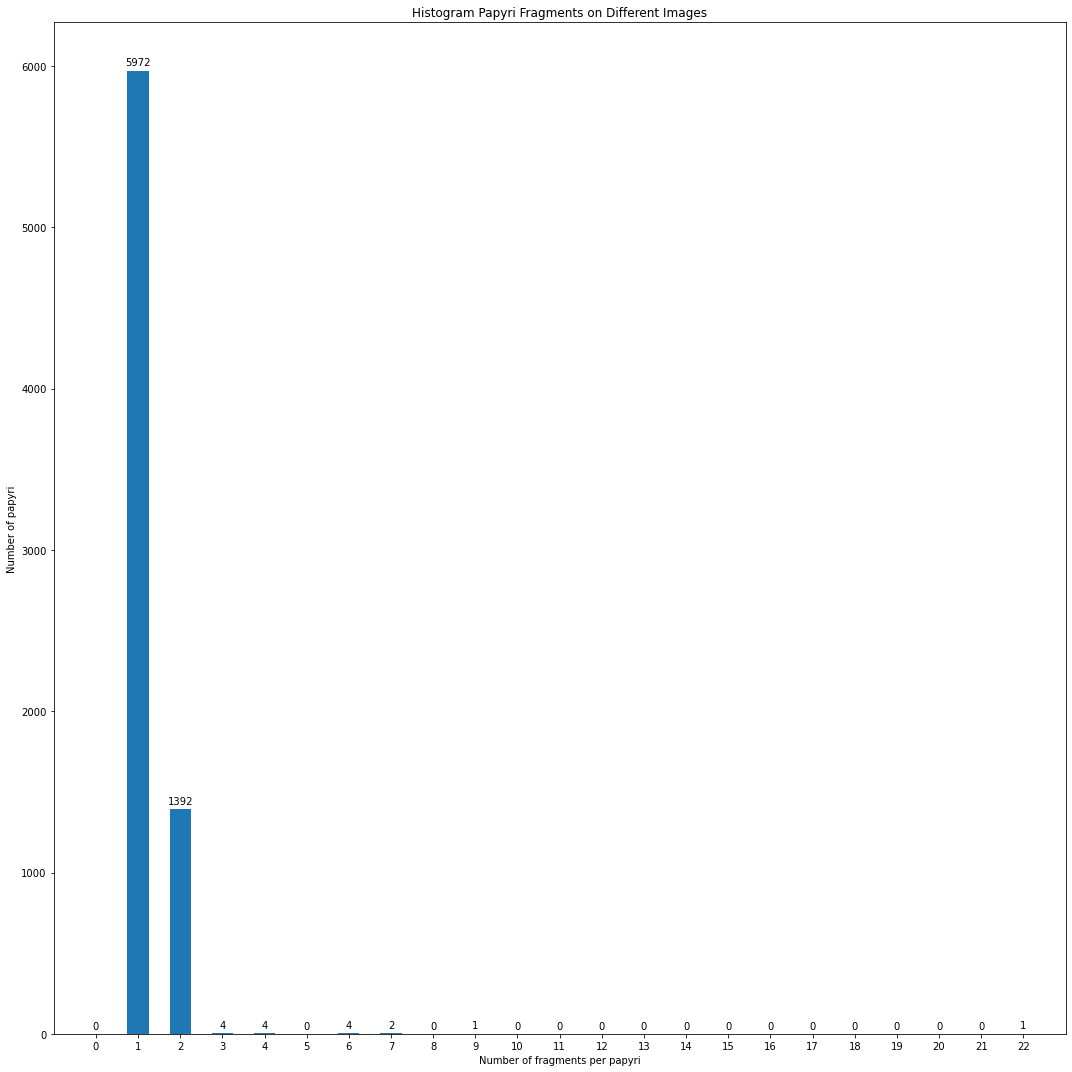

In [116]:
counts = np.bincount(id_series)

fig, ax = plt.subplots(figsize=(15,15))
rects = ax.bar(range(23), counts, width=.5, align='center')
ax.set(xticks=range(23), xlim=[-1, 23], title='Histogram Papyri Fragments on Different Images', ylabel='Number of papyri',xlabel='Number of fragments per papyri')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects)

fig.tight_layout()

plt.show()

In [155]:
info_frame

,fnames,papyID,posinfo,pixelCM_Y,pixelCM_X
0,11930_4233V,11930,V,231.298834,102.165627
1,13947_4857DV,13947,DV,97.818023,227.384677
2,10812_4101KR,10812,KR,100.425339,228.253931
3,13912_4803FV,13912,FV,229.122153,97.819632
4,10752_4097Z20R,10752,ZR,181.294879,412.601164
...,...,...,...,...,...
8848,12086_4240LV,12086,LV,99.556818,228.255498
8849,11368_4139BR,11368,BR,139.123257,60.427198
8850,15493_3585WR,15493,WR,99.121569,227.384945
8851,8607_2155R,8607,R,229.990194,99.557066


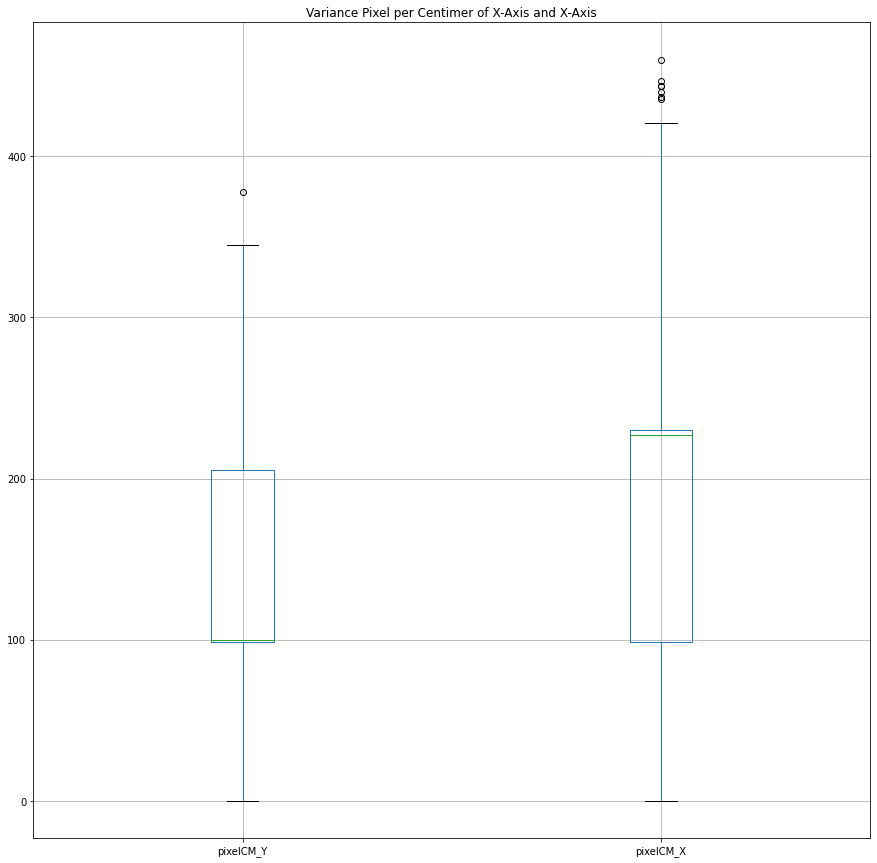

In [164]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Variance Pixel per Centimer of X-Axis and X-Axis')
info_frame[['pixelCM_Y','pixelCM_X']].boxplot()
plt.show()